<a href="https://colab.research.google.com/github/Thandriss/telecom_labs/blob/main/Makhonko_lab6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
# Get thinkdsp.py

import os

if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py
if not os.path.exists('thinkplot.py'):
  !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkplot.py
import thinkplot

--2022-04-14 10:04:39--  https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkplot.py
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AllenDowney/ThinkDSP/master/code/thinkplot.py [following]
--2022-04-14 10:04:39--  https://raw.githubusercontent.com/AllenDowney/ThinkDSP/master/code/thinkplot.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22756 (22K) [text/plain]
Saving to: ‘thinkplot.py’

thinkplot.py        100%[===================>]  22.22K  --.-KB/s    in 0s      

2022-04-14 10:04:39 (89.9 MB/s) - ‘thinkplot.py’ saved [22756/22756]



In [28]:
import numpy as np
import matplotlib.pyplot as plt

from thinkdsp import decorate
import warnings
import scipy.fftpack

##Упражнение 1


Убедимся в том, что analyze1 требует времени пропорционально n^3, a analyze1 пропорционально n^2. Для этого будем запускать их с несколькими разными массивами и засекать время
работы с помощью команды %timeit.
Для начала возьмем шумовой сигнал и массив со степенями двойки от 6 до 13

In [15]:
from thinkdsp import UncorrelatedGaussianNoise

signal = UncorrelatedGaussianNoise()
noise = signal.make_wave(duration=1.0, framerate=8192)
noise.ys.shape

(8192,)

In [16]:
ns = 2 ** np.arange(6, 13)
ns

array([  64,  128,  256,  512, 1024, 2048, 4096])

plot_bests берет массив результата из эксперемента, строит графики.

In [18]:
def plot_bests(bests):
  thinkplot.plot(ns, bests)
  thinkplot.config(xscale='log', yscale='log', legend=False)
  x = np.log(ns)
  y = np.log(bests)
  t = scipy.stats.linregress(x,y)
  slope = t[0]
  return slope

Результаты для analyze1.

In [23]:
PI2 = np.pi * 2

def analyze1(ys, fs, ts):
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = np.linalg.solve(M, ys)
    return amps

64
1000 loops, best of 1: 214 µs per loop
128
1000 loops, best of 1: 817 µs per loop
256
100 loops, best of 1: 6.68 ms per loop
512
10 loops, best of 1: 20.2 ms per loop
1024
10 loops, best of 1: 74.3 ms per loop
2048
1 loop, best of 1: 553 ms per loop
4096
1 loop, best of 1: 3.61 s per loop


2.3003052570221043

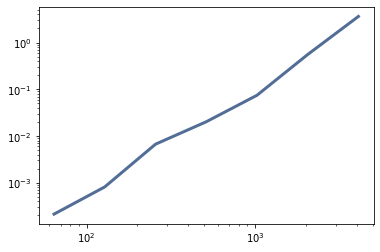

In [29]:
results = []
for N in ns:
  print(N)
  ts = (0.5 + np.arange(N)) / N
  freqs = (0.5 + np.arange(N)) / 2
  ys = noise.ys[:N]
  result = %timeit -r1 -o analyze1(ys, freqs, ts)
  results.append(result)

bests = [result.best for result in results]
plot_bests(bests)

Как говорится в пособии и chap06starter расчетный уклон ближе к степени двойки, чем
тройки. Производительность np.linalg.solve почти квадратична в этом диапозоне размеров
массива. К сожеланию, из-за малой мощности рабочей машины, не удалось протестировать
analyze1 со заничением 16384 Из графика видно, что линия в конце чуть-чуть изогнута, что
говорит о том, что размер массива не достигнут, где analyze1 показывает рост пропорцио-
нально n3. Из этого можно сделать вывод, что при больших размерах массива, рост analyze1
будет пропорционален n^3.
Проведем такой же эксперимент для analyze2

In [30]:
def analyze2(ys, fs, ts):
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = np.dot(M, ys) / 2
    return amps

64
1 loop, best of 1: 3.65 s per loop
128
1 loop, best of 1: 3.6 s per loop
256
1 loop, best of 1: 3.55 s per loop
512
1 loop, best of 1: 3.63 s per loop
1024
1 loop, best of 1: 3.61 s per loop
2048
1 loop, best of 1: 3.63 s per loop
4096
1 loop, best of 1: 3.57 s per loop


-0.0016495303647609926

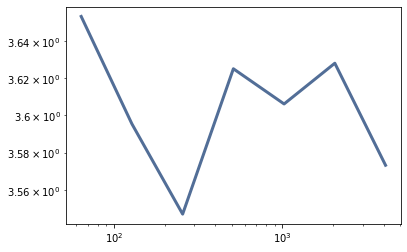

In [32]:
bests2 = run_speed_test(ns, analyze2)
plot_bests(bests2)

Как видно из графика, analyze2 растет пропорционально n^2. Проведем такой же эксперимент
scipy.fftpack.dct.

In [33]:
import scipy.fftpack

def scipy_dct(ys, freqs, ts):
    return scipy.fftpack.dct(ys, type=3)

The slowest run took 101.97 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 5.65 µs per loop
The slowest run took 12.14 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 6 µs per loop
The slowest run took 8.50 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 6.61 µs per loop
The slowest run took 9.85 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 8.15 µs per loop
The slowest run took 7.49 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 11.3 µs per loop
The slowest run took 14.34 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 17.9 µs per loop
The slowest run took 7.75 times longer 

0.4187415051533611

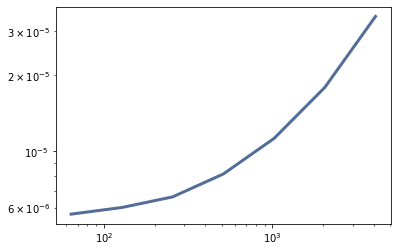

In [50]:
results = []
for N in ns:
  ys = noise.ys[:N]
  result = %timeit -o scipy.fftpack.dct(ys, type=3)
  results.append(result)
bests3 = [result.best for result in results]
plot_bests(bests3)

dct реализация намного быстрее, она пропорциональна n log n, но на графике этого не видно.

## Упражнение 2

В этом задании нужно реализовать алгоритм ДКП для сжатия звука и изображений. В качестве сжимаемого файла возьмем страшный звук трубы. Выделим из него короткий сегмент.

In [37]:
if not os.path.exists('447951__nowherestudios__saxophone-2-tenor-unprocessed.wav'):
    !wget https://github.com/Thandriss/telecom_labs/raw/main/447951__nowherestudios__saxophone-2-tenor-unprocessed.wav

--2022-04-14 10:13:55--  https://github.com/Thandriss/telecom_labs/raw/main/447951__nowherestudios__saxophone-2-tenor-unprocessed.wav
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Thandriss/telecom_labs/main/447951__nowherestudios__saxophone-2-tenor-unprocessed.wav [following]
--2022-04-14 10:13:56--  https://raw.githubusercontent.com/Thandriss/telecom_labs/main/447951__nowherestudios__saxophone-2-tenor-unprocessed.wav
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6350304 (6.1M) [application/octet-stream]
Saving to: ‘447951__nowherestudios__saxophone-2-tenor-unprocessed.wav’

447951__nowhere

In [39]:
from thinkdsp import read_wave

wave = read_wave('447951__nowherestudios__saxophone-2-tenor-unprocessed.wav')
wave.make_audio()

In [40]:
segment = wave.segment(start=1.2, duration=0.5)
segment.normalize()
segment.make_audio()

DCT график для полученного сегмента:

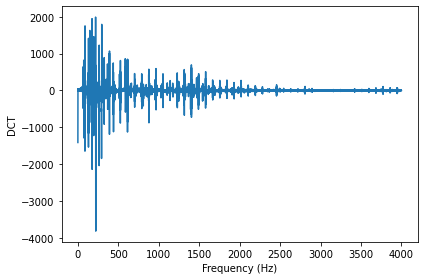

In [41]:
seg_dct = segment.make_dct()
seg_dct.plot(high=4000)
decorate(xlabel='Frequency (Hz)', ylabel='DCT')

Из графика видно, что есть немного частот с большой амплитудой. Следующая функция
compress берет DCT и режет элемент, которые ниже аргумента thresh.

In [42]:
def compress(dct, thresh=1):
    count = 0
    for i, amp in enumerate(dct.amps):
        if np.abs(amp) < thresh:
            dct.hs[i] = 0
            count += 1
            
    n = len(dct.amps)
    print(count, n, 100 * count / n, sep='\t')

Применим функцию для нашего сегмента:

42206	48000	87.92916666666666


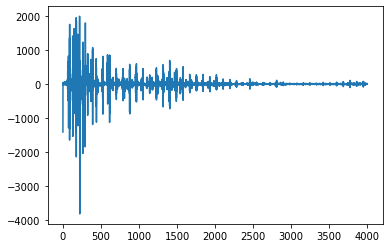

In [43]:
seg_dct = segment.make_dct()
compress(seg_dct, thresh=10)
seg_dct.plot(high=4000)

In [44]:
seg2 = seg_dct.make_wave()
seg2.make_audio()

In [45]:
from thinkdsp import Spectrogram

def make_dct_spectrogram(wave, seg_length):
    window = np.hamming(seg_length)
    i, j = 0, seg_length
    step = seg_length // 2

    spec_map = {}

    while j < len(wave.ys):
        segment = wave.slice(i, j)
        segment.window(window)

        t = (segment.start + segment.end) / 2
        spec_map[t] = segment.make_dct()

        i += step
        j += step

    return Spectrogram(spec_map, seg_length)

In [46]:
spectro = make_dct_spectrogram(wave, seg_length=1024)
for t, dct in sorted(spectro.spec_map.items()):
    compress(dct, thresh=0.2)

943	1024	92.08984375
923	1024	90.13671875
958	1024	93.5546875
907	1024	88.57421875
919	1024	89.74609375
941	1024	91.89453125
916	1024	89.453125
952	1024	92.96875
900	1024	87.890625
947	1024	92.48046875
937	1024	91.50390625
959	1024	93.65234375
952	1024	92.96875
925	1024	90.33203125
896	1024	87.5
870	1024	84.9609375
883	1024	86.23046875
944	1024	92.1875
832	1024	81.25
789	1024	77.05078125
606	1024	59.1796875
662	1024	64.6484375
767	1024	74.90234375
565	1024	55.17578125
696	1024	67.96875
462	1024	45.1171875
510	1024	49.8046875
446	1024	43.5546875
444	1024	43.359375
442	1024	43.1640625
421	1024	41.11328125
436	1024	42.578125
434	1024	42.3828125
464	1024	45.3125
463	1024	45.21484375
462	1024	45.1171875
420	1024	41.015625
484	1024	47.265625
427	1024	41.69921875
471	1024	45.99609375
484	1024	47.265625
433	1024	42.28515625
470	1024	45.8984375
470	1024	45.8984375
432	1024	42.1875
506	1024	49.4140625
446	1024	43.5546875
505	1024	49.31640625
473	1024	46.19140625
452	1024	44.140625
496	1024	48.43

In [47]:
wave2 = spectro.make_wave()
wave2.make_audio()

In [48]:
wave.make_audio()